# MODELOS DE REGRESSÃO 

Estamos interessados na possibilidade de prever a média das notas objetivas e de redação dos estudantes que fizeram o Enem no ano de 2023 a partir de seus dados socioeconômicos.

Inicialmente, consideramos os resultados dos estudantes dos quais se tem informação sobre todas as variáveis socioeconômicas.

Em um segundo momento, consideraremos excluir os dados outliers (da média das notas objetivas).

De forma geral, não teremos um modelo que se adapte completamente bem aos resultados. Dos modelos testados, os que têm uma melhor aproximação e apresentam um melhor padrão de comportamento em relação à média das notas objetivas são o RandomForest e o XGBRegressor.

Para a variável Nota de Redação, não se encontrou um modelo aceitável.

### Separação de Dados

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

from sklearn.preprocessing import OrdinalEncoder

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor


from sklearn.metrics import mean_absolute_error, mean_squared_error


In [2]:
def pipeline_dadosIniciais(arquivo):
    colunas = ["IN_TREINEIRO", 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO', 
               "TP_ESCOLA", "SG_UF_ESC", "TP_LOCALIZACAO_ESC", 
               'Q001', 'Q002', 'Q005', 'Q006', 'Q007', "Q010", "Q011", "Q012", "Q019", 'Q021', 'Q022', 'Q024', 'Q025'  ]

    dados =  pd.read_csv(
        'MICRODADOS_ENEM_2023.csv',
        encoding = 'latin1',
        usecols = colunas,
        sep = ';'
    )

    dados = dados.loc[(dados["NU_NOTA_CN"] != 0)  & (dados["NU_NOTA_CH"] != 0)  & (dados["NU_NOTA_LC"] != 0) 
                     & (dados["NU_NOTA_MT"] != 0) & (dados["NU_NOTA_REDACAO"] != 0) ]

    dados["Media_Notas_Objetivas"] = dados[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT']].mean(axis=1)

    dados = dados.loc[dados["IN_TREINEIRO"]==0]

    dados = dados.loc[ (dados["TP_ESCOLA"]==2) | (dados["TP_ESCOLA"]==3) ]

    dados.drop('IN_TREINEIRO', axis=1, inplace=True)

    dados.dropna(inplace=True) 
    # os dados nulos referem à (não informação do estado e tipo de escola) ou (falta de notas)

    return dados


In [3]:
dados = pipeline_dadosIniciais('MICRODADOS_ENEM_2023.csv')

In [4]:
dados

,TP_ESCOLA,SG_UF_ESC,TP_LOCALIZACAO_ESC,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,Q001,Q002,...,Q007,Q010,Q011,Q012,Q019,Q021,Q022,Q024,Q025,Media_Notas_Objetivas
3,2,CE,1.0,459.0,508.5,507.2,466.7,880.0,D,D,...,A,A,A,B,B,A,D,A,B,485.350
4,2,CE,1.0,402.5,379.2,446.9,338.3,560.0,B,B,...,A,A,A,B,B,A,B,A,A,391.725
11,2,PR,1.0,608.2,667.6,607.9,691.9,780.0,D,E,...,A,B,A,B,B,A,B,B,B,643.900
16,2,PA,1.0,515.7,553.1,544.4,437.0,880.0,E,E,...,A,A,A,B,B,A,D,A,B,512.550
41,2,SP,1.0,523.8,576.3,596.5,628.1,600.0,C,C,...,A,A,A,B,B,A,B,A,B,581.175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3933919,2,RS,1.0,557.3,546.2,532.3,539.4,600.0,B,E,...,A,B,B,B,B,A,D,A,B,543.800
3933921,2,RS,1.0,585.1,437.6,601.0,554.7,320.0,E,H,...,A,C,A,B,E,B,E,B,B,544.600
3933940,2,RS,1.0,600.7,611.2,661.6,666.2,760.0,E,F,...,A,B,A,B,E,A,E,D,B,634.925
3933944,3,RS,1.0,444.0,511.4,514.8,444.9,600.0,C,E,...,A,C,A,B,D,B,E,B,B,478.775


In [5]:
colunas_socioEconomicas = ["TP_ESCOLA", "SG_UF_ESC", "TP_LOCALIZACAO_ESC", 
               'Q001', 'Q002', 'Q005', 'Q006', 'Q007', "Q010", "Q011", "Q012", "Q019", 'Q021', 'Q022', 'Q024', 'Q025' ]

# Separamos as  features
dados_features = dados[colunas_socioEconomicas]

In [7]:
# Separamos nossas varieveis a predizer 
dados_NotaRedacao = dados["NU_NOTA_REDACAO"]
dados_NotaMediaObjetiva = dados["Media_Notas_Objetivas"]

### Tratando varaiveis categóricas 

Para o tratamento das variáveis categóricas, consideraremos dois casos: as variáveis cujos valores têm um grau de ordenação (ordinais) e as variáveis nominais.

Para as variáveis ordinais, consideraremos uma transformação com OrdinalEncoder.
No caso das variáveis nominais, geraremos novas variáveis dummies.

In [8]:

ordinalEncoder = OrdinalEncoder()

In [9]:
def pipeline_tratamento_variaveisCatregoricas(data):

    data_ = data
    variaveis_ordenadas = ['Q001', 'Q002', 'Q005', 'Q006', 'Q007', "Q010", "Q011", "Q012", "Q019", 'Q021', 'Q022', 'Q024', 'Q025']
    onehot_enc_features = [ "TP_ESCOLA", "SG_UF_ESC", "TP_LOCALIZACAO_ESC" ]
    
    data_[variaveis_ordenadas] = ordinalEncoder.fit_transform(data_[variaveis_ordenadas])
    data_ = pd.get_dummies(data_, prefix=onehot_enc_features, columns=onehot_enc_features, drop_first=True).astype(int)

    return data_


In [10]:
dados_features = pipeline_tratamento_variaveisCatregoricas(dados_features)

In [11]:
dados_features.columns

Index(['Q001', 'Q002', 'Q005', 'Q006', 'Q007', 'Q010', 'Q011', 'Q012', 'Q019',
       'Q021', 'Q022', 'Q024', 'Q025', 'TP_ESCOLA_3', 'SG_UF_ESC_AL',
       'SG_UF_ESC_AM', 'SG_UF_ESC_AP', 'SG_UF_ESC_BA', 'SG_UF_ESC_CE',
       'SG_UF_ESC_DF', 'SG_UF_ESC_ES', 'SG_UF_ESC_GO', 'SG_UF_ESC_MA',
       'SG_UF_ESC_MG', 'SG_UF_ESC_MS', 'SG_UF_ESC_MT', 'SG_UF_ESC_PA',
       'SG_UF_ESC_PB', 'SG_UF_ESC_PE', 'SG_UF_ESC_PI', 'SG_UF_ESC_PR',
       'SG_UF_ESC_RJ', 'SG_UF_ESC_RN', 'SG_UF_ESC_RO', 'SG_UF_ESC_RR',
       'SG_UF_ESC_RS', 'SG_UF_ESC_SC', 'SG_UF_ESC_SE', 'SG_UF_ESC_SP',
       'SG_UF_ESC_TO', 'TP_LOCALIZACAO_ESC_2.0'],
      dtype='object')

### Regressão Linear 

In [12]:
linearR = LinearRegression()

#### Nota Redação

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    dados_features, dados_NotaRedacao, test_size=0.3, random_state=42)

linearR.fit(X_train, y_train)

y_predict = linearR.predict(X_test)

mean_squared_error(y_test, y_predict)

25027.894618230737

Text(0, 0.5, 'Valores Preditos')

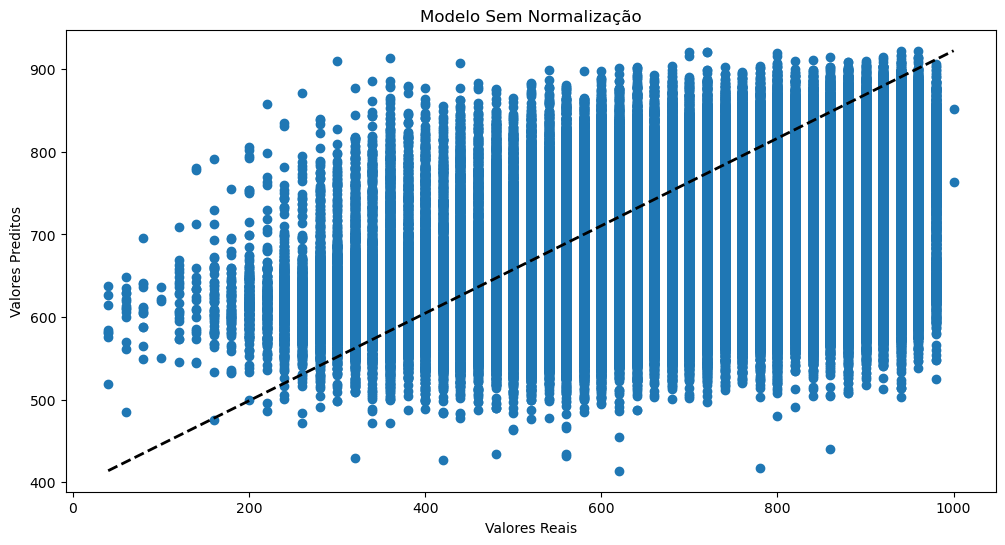

In [14]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_predict)
plt.plot([y_test.min(), y_test.max()], [y_predict.min(),y_predict.max()], 'k--', lw=2)
plt.title('Modelo Sem Normalização')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')


Como se pode apreciar no gráfico anterior, uma regressão linear não é um bom modelo para os dados referentes às notas de Redação.

#### Nota Média Provas Objetivas

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    dados_features, dados_NotaMediaObjetiva, test_size=0.3, random_state=42)

linearR.fit(X_train, y_train)

y_predict = linearR.predict(X_test)

mean_squared_error(y_test, y_predict)

4203.130940228666

Text(0, 0.5, 'Valores Preditos')

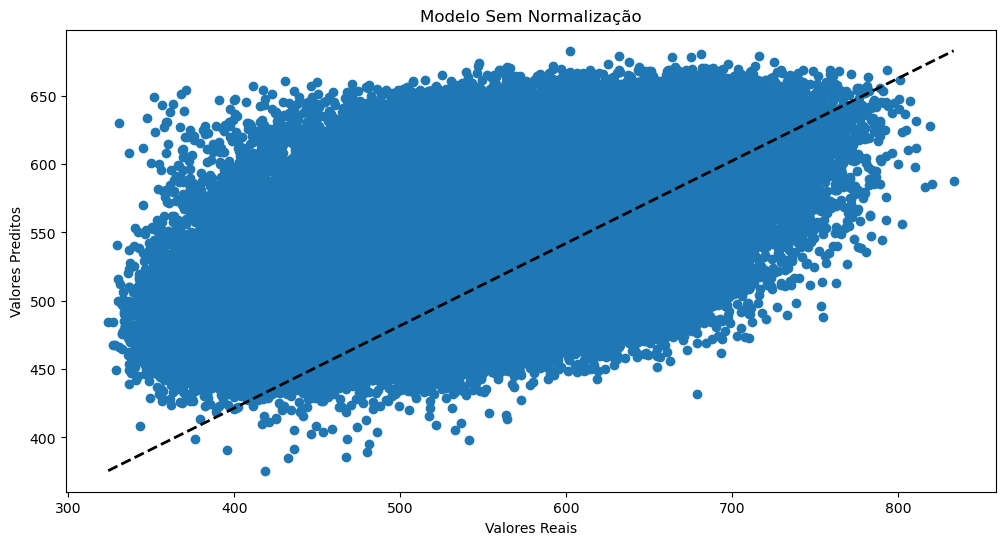

In [16]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_predict)
plt.plot([y_test.min(), y_test.max()], [y_predict.min(),y_predict.max()], 'k--', lw=2)
plt.title('Modelo Sem Normalização')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')

No caso das médias das notas objetivas, a regressão linear resulta ser um pouco melhor do que no caso das notas de Redação. Temos um melhor padrão, ainda assim, considerando a quantidade de dados, não resulta ser um modelo suficientemente bom.

### Normalizando dados

Procurando melhores resultados, consideramos escalonar os dados das nossas features.

Como se poderá ver, não teremos diferenças consideráveis.

In [17]:
scaler = StandardScaler()

In [18]:
dados_features_esc = scaler.fit_transform(dados_features)

dados_features_esc = pd.DataFrame(dados_features_esc, columns= dados_features.columns)


In [19]:
dados_features_esc

,Q001,Q002,Q005,Q006,Q007,Q010,Q011,Q012,Q019,Q021,...,SG_UF_ESC_RJ,SG_UF_ESC_RN,SG_UF_ESC_RO,SG_UF_ESC_RR,SG_UF_ESC_RS,SG_UF_ESC_SC,SG_UF_ESC_SE,SG_UF_ESC_SP,SG_UF_ESC_TO,TP_LOCALIZACAO_ESC_2.0
0,-0.491898,-0.700053,0.946867,-0.623116,-0.315631,-0.999290,-0.540492,-0.220014,-0.559304,-0.641717,...,-0.27288,-0.143643,-0.098244,-0.046966,-0.217686,-0.185369,-0.108735,-0.500512,-0.082922,-0.184063
1,-1.598525,-2.006544,0.133586,-0.871451,-0.315631,-0.999290,-0.540492,-0.220014,-0.559304,-0.641717,...,-0.27288,-0.143643,-0.098244,-0.046966,-0.217686,-0.185369,-0.108735,-0.500512,-0.082922,-0.184063
2,-0.491898,-0.046807,0.946867,-0.374781,-0.315631,0.312722,-0.540492,-0.220014,-0.559304,-0.641717,...,-0.27288,-0.143643,-0.098244,-0.046966,-0.217686,-0.185369,-0.108735,-0.500512,-0.082922,-0.184063
3,0.061415,-0.046807,0.133586,-0.871451,-0.315631,-0.999290,-0.540492,-0.220014,-0.559304,-0.641717,...,-0.27288,-0.143643,-0.098244,-0.046966,-0.217686,-0.185369,-0.108735,-0.500512,-0.082922,-0.184063
4,-1.045211,-1.353299,-1.492977,-0.374781,-0.315631,-0.999290,-0.540492,-0.220014,-0.559304,-0.641717,...,-0.27288,-0.143643,-0.098244,-0.046966,-0.217686,-0.185369,-0.108735,1.997955,-0.082922,-0.184063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689246,-1.598525,-0.046807,0.133586,-0.623116,-0.315631,0.312722,1.323998,-0.220014,-0.559304,-0.641717,...,-0.27288,-0.143643,-0.098244,-0.046966,4.593769,-0.185369,-0.108735,-0.500512,-0.082922,-0.184063
689247,0.061415,1.912930,-0.679696,0.618561,-0.315631,1.624734,-0.540492,-0.220014,2.690643,1.558319,...,-0.27288,-0.143643,-0.098244,-0.046966,4.593769,-0.185369,-0.108735,-0.500512,-0.082922,-0.184063
689248,0.061415,0.606439,-0.679696,0.370225,-0.315631,0.312722,-0.540492,-0.220014,2.690643,-0.641717,...,-0.27288,-0.143643,-0.098244,-0.046966,4.593769,-0.185369,-0.108735,-0.500512,-0.082922,-0.184063
689249,-1.045211,-0.046807,0.133586,1.363567,-0.315631,1.624734,-0.540492,-0.220014,1.607327,1.558319,...,-0.27288,-0.143643,-0.098244,-0.046966,4.593769,-0.185369,-0.108735,-0.500512,-0.082922,-0.184063


##### Media Objetiva

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    dados_features_esc, dados_NotaMediaObjetiva, test_size=0.3, random_state=42, stratify=dados_features_esc["TP_ESCOLA_3"])

linearR.fit(X_train, y_train)

y_predict = linearR.predict(X_test)

mean_squared_error(y_test, y_predict)

4192.102148036217

Text(0, 0.5, 'Valores Preditos')

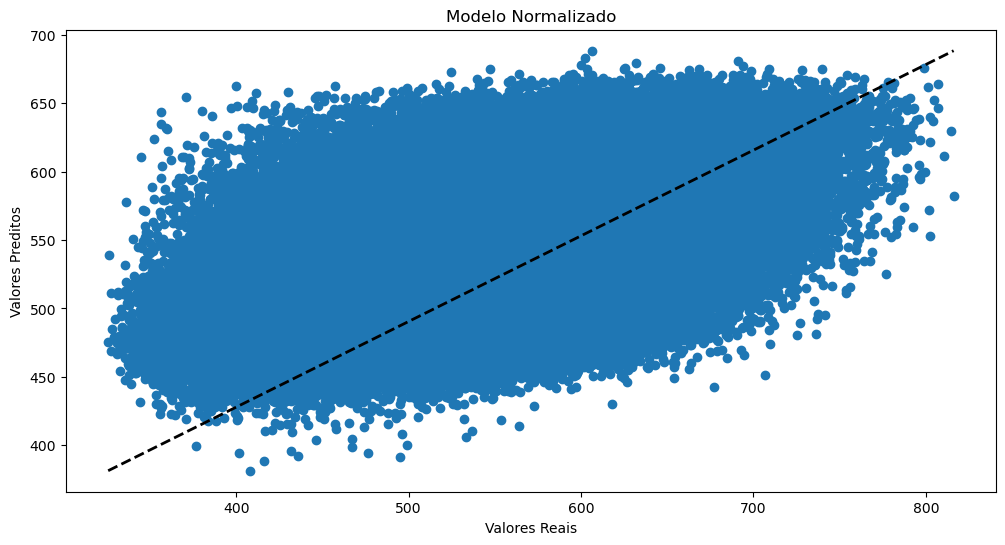

In [21]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_predict)
plt.plot([y_test.min(), y_test.max()], [y_predict.min(),y_predict.max()], 'k--', lw=2)
plt.title('Modelo Normalizado')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')

##### Redação


In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    dados_features_esc, dados_NotaRedacao, test_size=0.3, random_state=42, stratify=dados_features_esc["TP_ESCOLA_3"])

linearR.fit(X_train, y_train)

y_predict = linearR.predict(X_test)

mean_squared_error(y_test, y_predict)

24990.397667317462

Text(0, 0.5, 'Valores Preditos')

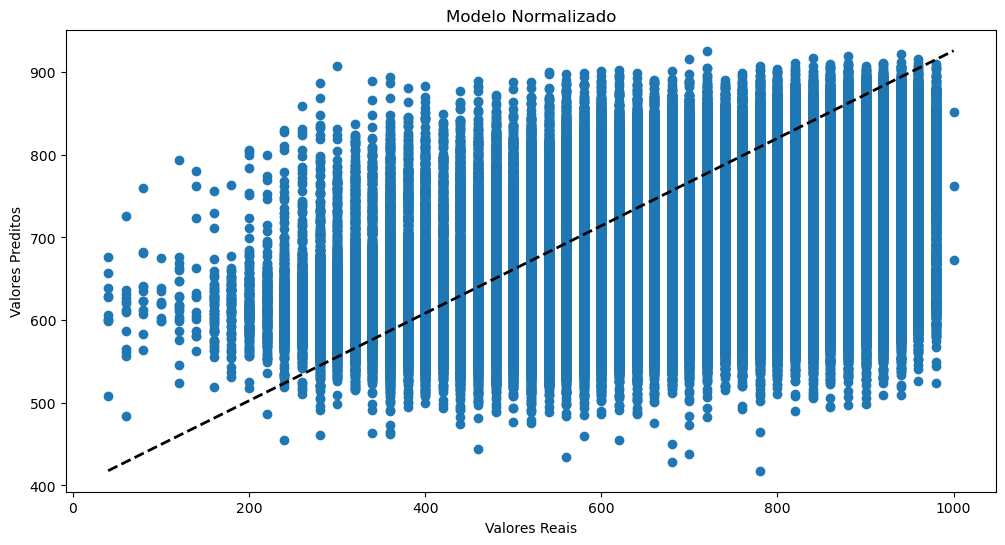

In [23]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_predict)
plt.plot([y_test.min(), y_test.max()], [y_predict.min(),y_predict.max()], 'k--', lw=2)
plt.title('Modelo Normalizado')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')

In [24]:
dados_features_esc.shape

(689251, 41)

## RamdomForestRegressor 

Consideramos agora o modelo  RandomForestRegressor.

Ralizando diferentes alterações em hiperparámetros, obtivemos melhores resultados considerando uma profundidade máxima de 15. 

### Media Nota Objetiva

In [25]:


X_train, X_test, y_train, y_test = train_test_split(
    dados_features_esc, dados_NotaMediaObjetiva, test_size=0.3, random_state=42, stratify=dados_features_esc["TP_ESCOLA_3"])

regr = RandomForestRegressor(max_depth=15, random_state=17)

regr.fit(X_train, y_train)



RandomForestRegressor(max_depth=15, random_state=17)

In [26]:

y_predict = regr.predict(X_test)

mean_squared_error(y_test, y_predict)

4088.313855704558

In [27]:
mean_squared_error(y_train, regr.predict(X_train))

3645.1867672660724

Text(0, 0.5, 'Valores Preditos')

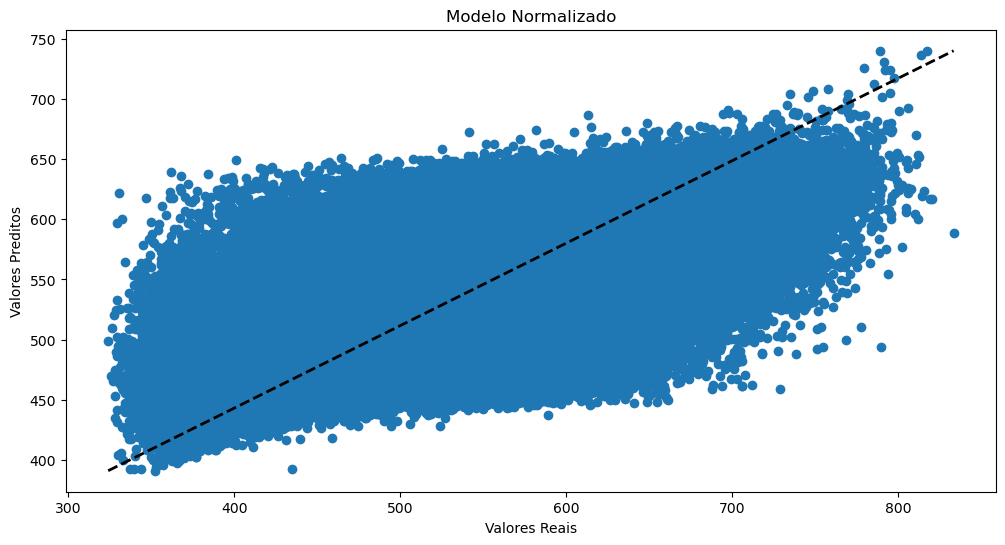

In [28]:
plt.figure(figsize=(12, 6))
plt.scatter(y_train, regr.predict(X_train))
plt.plot([y_train.min(), y_train.max()], [regr.predict(X_train).min(),regr.predict(X_train).max()], 'k--', lw=2)
plt.title('Modelo Normalizado')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')

### Nota redação

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    dados_features_esc, dados_NotaRedacao, test_size=0.3, random_state=42, stratify=dados_features_esc["TP_ESCOLA_3"])

regr = RandomForestRegressor(max_depth=15, random_state=17)

regr.fit(X_train, y_train)

y_predict = regr.predict(X_test)

mean_squared_error(y_test, y_predict)


24491.067974601843

In [30]:
mean_squared_error(y_train, regr.predict(X_train))

22569.13305874788

Text(0, 0.5, 'Valores Preditos')

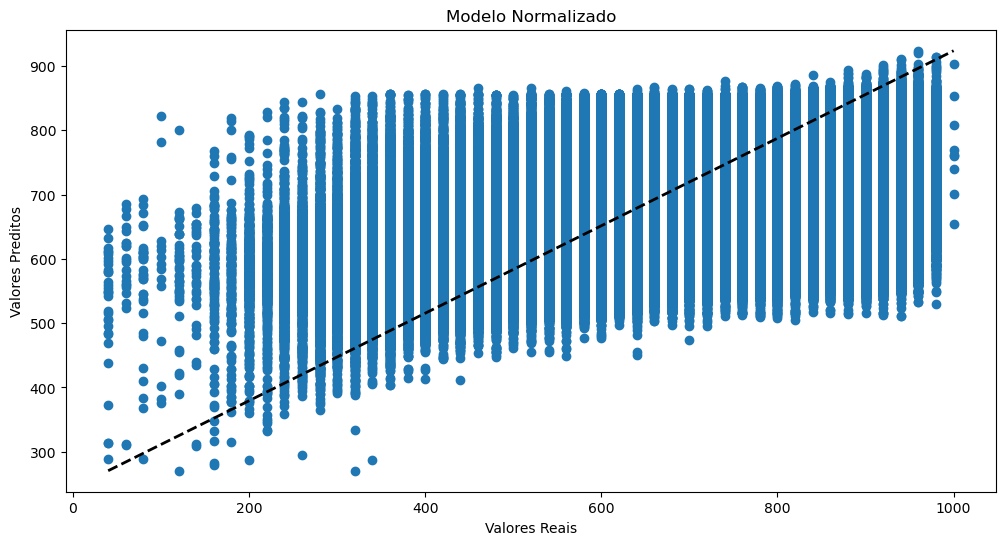

In [31]:
plt.figure(figsize=(12, 6))
plt.scatter(y_train, regr.predict(X_train))
plt.plot([y_train.min(), y_train.max()], [regr.predict(X_train).min(),regr.predict(X_train).max()], 'k--', lw=2)
plt.title('Modelo Normalizado')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')

## XGBRegressor

In [32]:
from xgboost import XGBRegressor

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    dados_features_esc, dados_NotaMediaObjetiva, test_size=0.3, random_state=17, stratify=dados_features_esc["TP_ESCOLA_3"])

In [34]:
xgboost = XGBRegressor(n_estimators=300, max_depth=15, learning_rate=0.02, objective="reg:squarederror", random_state=17)
xgboost.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=17, ...)

In [35]:
xgboost.score(X_train, y_train)

0.5121015633363399

In [36]:
xgboost.score(X_test, y_test)

0.3442367973652044

In [37]:
y_predict = xgboost.predict(X_test)

In [38]:
mean_squared_error(y_test, y_predict)

4106.882447202533

In [39]:
mean_absolute_error(y_test, y_predict)

51.55188521955138

In [40]:
mean_squared_error(y_train,xgboost.predict(X_train))

3058.7705850301018

Text(0, 0.5, 'Valores Preditos')

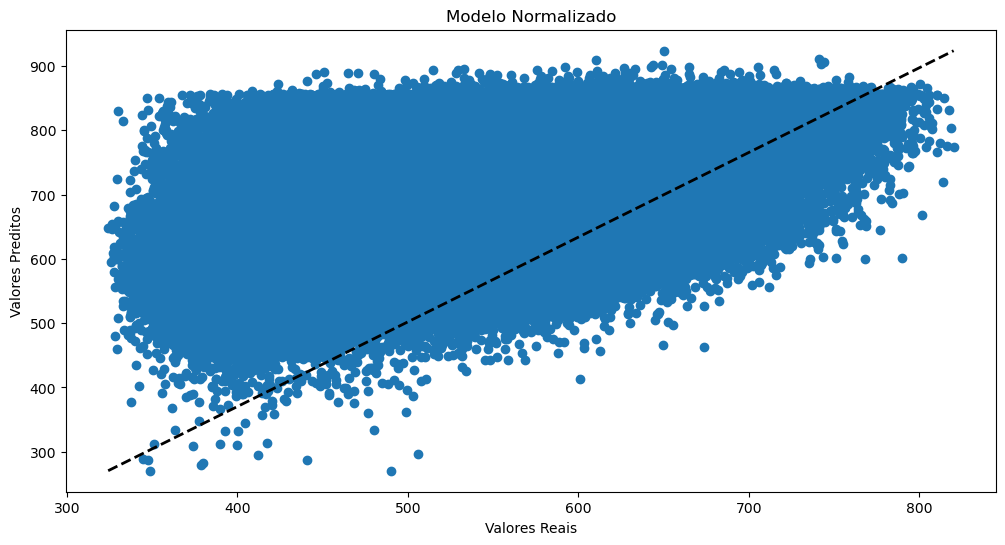

In [41]:
plt.figure(figsize=(12, 6))
plt.scatter(y_train, regr.predict(X_train))
plt.plot([y_train.min(), y_train.max()], [regr.predict(X_train).min(),regr.predict(X_train).max()], 'k--', lw=2)
plt.title('Modelo Normalizado')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')

## Outliers 


In [42]:
dados_NotaMediaObjetiva = pd.DataFrame(dados_NotaMediaObjetiva)

In [43]:
dados_NotaMediaObjetiva

,Media_Notas_Objetivas
3,485.350
4,391.725
11,643.900
16,512.550
41,581.175
...,...
3933919,543.800
3933921,544.600
3933940,634.925
3933944,478.775


In [44]:
dados_NotaMediaObjetiva.describe()

,Media_Notas_Objetivas
count,689251.000000
mean,528.824521
std,79.166470
min,324.125000
25%,469.050000
50%,525.875000
75%,585.350000
max,833.225000


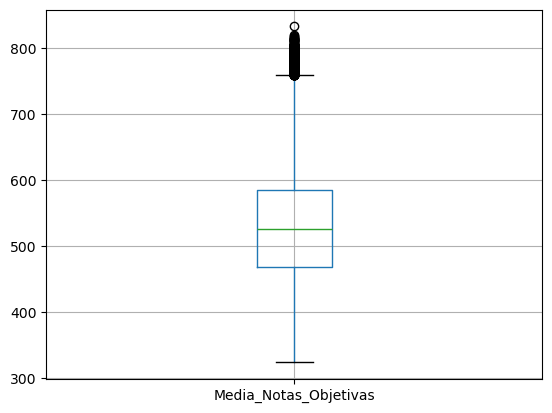

In [45]:
dados_NotaMediaObjetiva.boxplot()
plt.show()

In [46]:
Q1 = dados_NotaMediaObjetiva['Media_Notas_Objetivas'].quantile(0.25)
Q3 = dados_NotaMediaObjetiva['Media_Notas_Objetivas'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

116.2999999999999


In [47]:
lim_sup = Q3 + 1.5*IQR
print(lim_sup)

lim_inf = Q1 - 1.5*IQR
print(lim_inf)

759.7999999999997
294.60000000000014


In [48]:
dados_features_esc_r = dados_features_esc.reset_index(drop=True)
dados_NotaMediaObjetiva_r = dados_NotaMediaObjetiva.reset_index(drop=True)

dados_f_t_ = pd.concat([dados_features_esc_r,dados_NotaMediaObjetiva_r], axis=1)

In [49]:
dados_f_t_

,Q001,Q002,Q005,Q006,Q007,Q010,Q011,Q012,Q019,Q021,...,SG_UF_ESC_RN,SG_UF_ESC_RO,SG_UF_ESC_RR,SG_UF_ESC_RS,SG_UF_ESC_SC,SG_UF_ESC_SE,SG_UF_ESC_SP,SG_UF_ESC_TO,TP_LOCALIZACAO_ESC_2.0,Media_Notas_Objetivas
0,-0.491898,-0.700053,0.946867,-0.623116,-0.315631,-0.999290,-0.540492,-0.220014,-0.559304,-0.641717,...,-0.143643,-0.098244,-0.046966,-0.217686,-0.185369,-0.108735,-0.500512,-0.082922,-0.184063,485.350
1,-1.598525,-2.006544,0.133586,-0.871451,-0.315631,-0.999290,-0.540492,-0.220014,-0.559304,-0.641717,...,-0.143643,-0.098244,-0.046966,-0.217686,-0.185369,-0.108735,-0.500512,-0.082922,-0.184063,391.725
2,-0.491898,-0.046807,0.946867,-0.374781,-0.315631,0.312722,-0.540492,-0.220014,-0.559304,-0.641717,...,-0.143643,-0.098244,-0.046966,-0.217686,-0.185369,-0.108735,-0.500512,-0.082922,-0.184063,643.900
3,0.061415,-0.046807,0.133586,-0.871451,-0.315631,-0.999290,-0.540492,-0.220014,-0.559304,-0.641717,...,-0.143643,-0.098244,-0.046966,-0.217686,-0.185369,-0.108735,-0.500512,-0.082922,-0.184063,512.550
4,-1.045211,-1.353299,-1.492977,-0.374781,-0.315631,-0.999290,-0.540492,-0.220014,-0.559304,-0.641717,...,-0.143643,-0.098244,-0.046966,-0.217686,-0.185369,-0.108735,1.997955,-0.082922,-0.184063,581.175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689246,-1.598525,-0.046807,0.133586,-0.623116,-0.315631,0.312722,1.323998,-0.220014,-0.559304,-0.641717,...,-0.143643,-0.098244,-0.046966,4.593769,-0.185369,-0.108735,-0.500512,-0.082922,-0.184063,543.800
689247,0.061415,1.912930,-0.679696,0.618561,-0.315631,1.624734,-0.540492,-0.220014,2.690643,1.558319,...,-0.143643,-0.098244,-0.046966,4.593769,-0.185369,-0.108735,-0.500512,-0.082922,-0.184063,544.600
689248,0.061415,0.606439,-0.679696,0.370225,-0.315631,0.312722,-0.540492,-0.220014,2.690643,-0.641717,...,-0.143643,-0.098244,-0.046966,4.593769,-0.185369,-0.108735,-0.500512,-0.082922,-0.184063,634.925
689249,-1.045211,-0.046807,0.133586,1.363567,-0.315631,1.624734,-0.540492,-0.220014,1.607327,1.558319,...,-0.143643,-0.098244,-0.046966,4.593769,-0.185369,-0.108735,-0.500512,-0.082922,-0.184063,478.775


In [50]:
dados_f_t_iqr = dados_f_t_.loc[dados_f_t_['Media_Notas_Objetivas'] <= lim_sup]

In [51]:
dados_f_t_iqr

,Q001,Q002,Q005,Q006,Q007,Q010,Q011,Q012,Q019,Q021,...,SG_UF_ESC_RN,SG_UF_ESC_RO,SG_UF_ESC_RR,SG_UF_ESC_RS,SG_UF_ESC_SC,SG_UF_ESC_SE,SG_UF_ESC_SP,SG_UF_ESC_TO,TP_LOCALIZACAO_ESC_2.0,Media_Notas_Objetivas
0,-0.491898,-0.700053,0.946867,-0.623116,-0.315631,-0.999290,-0.540492,-0.220014,-0.559304,-0.641717,...,-0.143643,-0.098244,-0.046966,-0.217686,-0.185369,-0.108735,-0.500512,-0.082922,-0.184063,485.350
1,-1.598525,-2.006544,0.133586,-0.871451,-0.315631,-0.999290,-0.540492,-0.220014,-0.559304,-0.641717,...,-0.143643,-0.098244,-0.046966,-0.217686,-0.185369,-0.108735,-0.500512,-0.082922,-0.184063,391.725
2,-0.491898,-0.046807,0.946867,-0.374781,-0.315631,0.312722,-0.540492,-0.220014,-0.559304,-0.641717,...,-0.143643,-0.098244,-0.046966,-0.217686,-0.185369,-0.108735,-0.500512,-0.082922,-0.184063,643.900
3,0.061415,-0.046807,0.133586,-0.871451,-0.315631,-0.999290,-0.540492,-0.220014,-0.559304,-0.641717,...,-0.143643,-0.098244,-0.046966,-0.217686,-0.185369,-0.108735,-0.500512,-0.082922,-0.184063,512.550
4,-1.045211,-1.353299,-1.492977,-0.374781,-0.315631,-0.999290,-0.540492,-0.220014,-0.559304,-0.641717,...,-0.143643,-0.098244,-0.046966,-0.217686,-0.185369,-0.108735,1.997955,-0.082922,-0.184063,581.175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689246,-1.598525,-0.046807,0.133586,-0.623116,-0.315631,0.312722,1.323998,-0.220014,-0.559304,-0.641717,...,-0.143643,-0.098244,-0.046966,4.593769,-0.185369,-0.108735,-0.500512,-0.082922,-0.184063,543.800
689247,0.061415,1.912930,-0.679696,0.618561,-0.315631,1.624734,-0.540492,-0.220014,2.690643,1.558319,...,-0.143643,-0.098244,-0.046966,4.593769,-0.185369,-0.108735,-0.500512,-0.082922,-0.184063,544.600
689248,0.061415,0.606439,-0.679696,0.370225,-0.315631,0.312722,-0.540492,-0.220014,2.690643,-0.641717,...,-0.143643,-0.098244,-0.046966,4.593769,-0.185369,-0.108735,-0.500512,-0.082922,-0.184063,634.925
689249,-1.045211,-0.046807,0.133586,1.363567,-0.315631,1.624734,-0.540492,-0.220014,1.607327,1.558319,...,-0.143643,-0.098244,-0.046966,4.593769,-0.185369,-0.108735,-0.500512,-0.082922,-0.184063,478.775


In [52]:
dados_features_iqr = dados_f_t_iqr[dados_f_t_iqr.columns[:-1]]

dados_target_iqr = dados_f_t_iqr[dados_f_t_iqr.columns[-1]]


### XGBRegressor

In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    dados_features_iqr, dados_target_iqr, 
    test_size=0.3, random_state=17, stratify=dados_features_iqr["TP_ESCOLA_3"])

In [54]:
xgboost = XGBRegressor(n_estimators=300, max_depth=15, learning_rate=0.02, objective="reg:squarederror", random_state=17)
xgboost.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=17, ...)

In [55]:
y_predict = xgboost.predict(X_test)

In [56]:
print("mse:", mean_squared_error(y_test, y_predict))
print("mae:", mean_absolute_error(y_test, y_predict) )

mse: 4079.975499958867
mae: 51.493786409485274


In [57]:
mean_squared_error(y_train,xgboost.predict(X_train))

3032.415309892492

Text(0, 0.5, 'Valores Preditos')

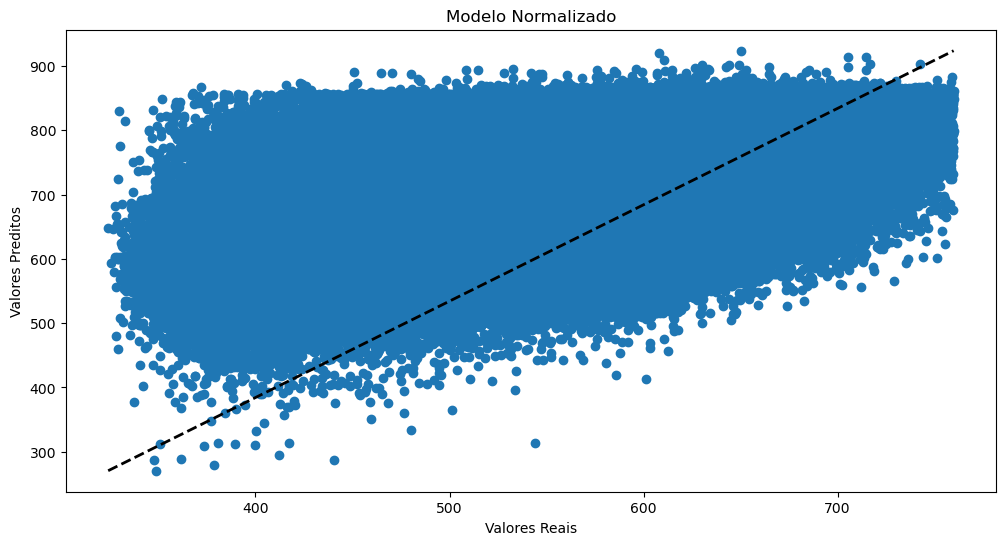

In [58]:
plt.figure(figsize=(12, 6))
plt.scatter(y_train, regr.predict(X_train))
plt.plot([y_train.min(), y_train.max()], [regr.predict(X_train).min(),regr.predict(X_train).max()], 'k--', lw=2)
plt.title('Modelo Normalizado')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')

### RandomForestRegressor


In [59]:

X_train, X_test, y_train, y_test = train_test_split(
    dados_features_iqr, dados_target_iqr, 
    test_size=0.3, random_state=17, stratify=dados_features_iqr["TP_ESCOLA_3"])

regr = RandomForestRegressor(max_depth=15, random_state=17)

regr.fit(X_train, y_train)



RandomForestRegressor(max_depth=15, random_state=17)

In [60]:
y_predict = regr.predict(X_test)

mean_squared_error(y_test, y_predict)

4054.7637422939433

In [61]:
mean_squared_error(y_train, regr.predict(X_train))

3627.496001954641

Text(0, 0.5, 'Valores Preditos')

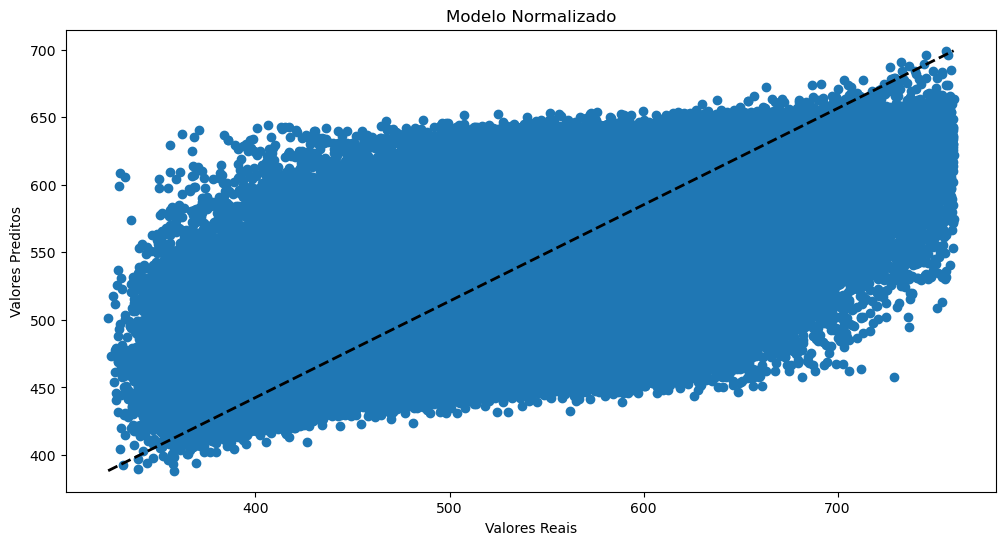

In [62]:
plt.figure(figsize=(12, 6))
plt.scatter(y_train, regr.predict(X_train))
plt.plot([y_train.min(), y_train.max()], [regr.predict(X_train).min(),regr.predict(X_train).max()], 'k--', lw=2)
plt.title('Modelo Normalizado')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')